Métricas de avaliação:

In [256]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from pathlib import Path
import numpy as np



In [257]:
CSV_PATH = Path("results/run_logs.csv")
COLS = ["modo","num_processos","tempo_clock","tempo_cpu",
        "tempo_comunicacao","tempo_total","timestamp","notas"]

In [258]:
def ler_csv(caminho: Path, cols: list[str]) -> pd.DataFrame:
    df = pd.read_csv(caminho, names=cols)
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    for c in ("tempo_clock","tempo_cpu","tempo_comunicacao","tempo_total","num_processos"):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

df = ler_csv(CSV_PATH, COLS)

Speedup

In [259]:
def speedup(T1, Tp):
    if Tp == 0 or np.isnan(Tp):
        return np.nan, "indefinido"
    S = T1 / Tp
    return S, None

In [260]:
def classificar_speedup(S, p):
    if np.isnan(S) or np.isnan(p) or p <= 0:
        return "indefinido"
    if S < p:
        return "sublinear"
    elif np.isclose(S, p, rtol=1e-6, atol=1e-9):
        return "linear"
    else:
        return "superlinear"

Eficiência

In [261]:
def eficiencia(S, p):
    if p == 0 or np.isnan(p):
        return np.nan
    return S / p

Redundância

In [262]:
def redundancia(tempo_cpu, tempo_clock):
    if tempo_clock == 0 or np.isnan(tempo_clock):
        return np.nan
    return tempo_cpu / tempo_clock

Utilização

In [263]:
def utilizacao(E, R):
    if R == 0 or np.isnan(R):
        return 0.0
    return E / R

Cálculos

In [264]:
metricas = []
for _, row in df.iterrows():
    Tp = float(row["tempo_clock"]) if pd.notna(row["tempo_clock"]) else np.nan
    p  = int(row["num_processos"]) if pd.notna(row["num_processos"]) else 1
    tempo_cpu = float(row["tempo_cpu"]) if pd.notna(row["tempo_cpu"]) else np.nan

    # Redundância (sua fórmula)
    R = redundancia(tempo_cpu, Tp)

    if row["modo"] == "linear":
        S = 1.0
        E = 1.0
        tipo_speedup = "linear"
    else:
        S, _ = speedup(T1, Tp)
        E = eficiencia(S, p)
        tipo_speedup = classificar_speedup(S, p)

    U = utilizacao(E, R)

    metricas.append({
        "modo": row["modo"],
        "num_processos": p,
        "Speedup": S,
        "Tipo Speedup": tipo_speedup,
        "Eficiência": E,
        "Redundância": R,
        "Utilização": U
    })

df_metricas = pd.DataFrame(metricas)
print(tabulate(df_metricas, headers="keys", tablefmt="fancy_grid", showindex=False))

╒════════════════╤═════════════════╤═════════════╤════════════════╤══════════════╤═══════════════╤══════════════╕
│ modo           │   num_processos │     Speedup │ Tipo Speedup   │   Eficiência │   Redundância │   Utilização │
╞════════════════╪═════════════════╪═════════════╪════════════════╪══════════════╪═══════════════╪══════════════╡
│ linear         │               1 │ 1           │ linear         │  1           │     0         │  0           │
├────────────────┼─────────────────┼─────────────┼────────────────┼──────────────┼───────────────┼──────────────┤
│ paralelo_local │               8 │ 6.98487e-09 │ sublinear      │  8.73109e-10 │     0.927197  │  9.41665e-10 │
├────────────────┼─────────────────┼─────────────┼────────────────┼──────────────┼───────────────┼──────────────┤
│ paralelo_local │               7 │ 1.22399e-08 │ sublinear      │  1.74856e-09 │     0.0242435 │  7.21246e-08 │
├────────────────┼─────────────────┼─────────────┼────────────────┼──────────────┼──────

Gráficos

Gráfico comparativo entre tempo (em segundos) a multiplicação linear (em um único núcleo)

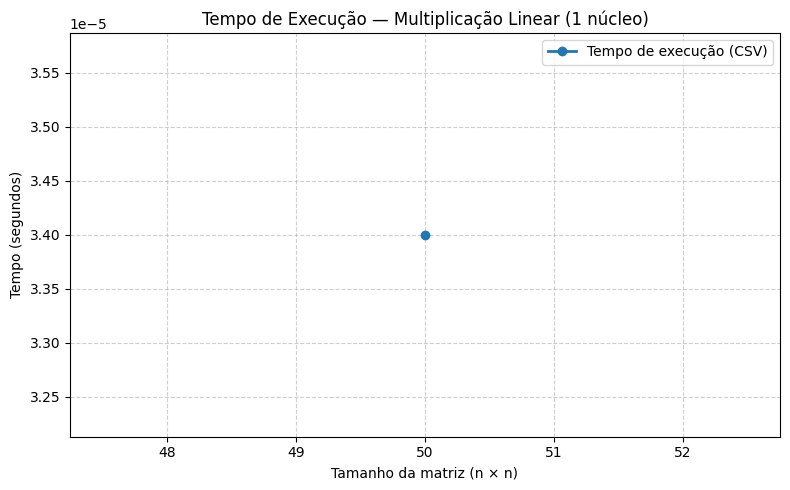

In [265]:
def plot_linear(df: pd.DataFrame):
    """Plota tempo × tamanho_n para modo linear (1 núcleo)."""
    df_lin = df[df["modo"] == "linear"].copy()
    if df_lin.empty:
        raise ValueError("Não há linhas do modo 'linear' no CSV. Rode o linear ou verifique o arquivo.")

    df_lin = df_lin.dropna(subset=["tempo_clock"]).sort_values("timestamp").reset_index(drop=True)

    if "tamanho_n" not in df_lin.columns:
        template_sizes = [50, 75, 100, 125, 150, 200, 250, 300, 400, 500]
        if len(df_lin) > len(template_sizes):
            template_sizes = list(range(50, 50*(len(df_lin)+1), 50))
        df_lin["tamanho_n"] = template_sizes[:len(df_lin)]

    df_lin["tamanho_n"] = pd.to_numeric(df_lin["tamanho_n"], errors="coerce")
    df_lin = df_lin.dropna(subset=["tamanho_n"]).sort_values("tamanho_n")

    plt.figure(figsize=(8,5))
    plt.plot(
        df_lin["tamanho_n"], df_lin["tempo_clock"],
        marker="o", linewidth=2, label="Tempo de execução (CSV)"
    )
    plt.title("Tempo de Execução — Multiplicação Linear (1 núcleo)")
    plt.xlabel("Tamanho da matriz (n × n)")
    plt.ylabel("Tempo (segundos)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_linear(df)

In [266]:
def plot_por_processos(df: pd.DataFrame, modo: str, titulo: str):
    """Plota tempo × num_processos para um modo específico."""
    dff = df[df["modo"] == modo].copy()
    if dff.empty:
        print(f"Aviso: não há linhas com modo '{modo}'.")
        return
    dff = dff.dropna(subset=["num_processos","tempo_clock"]).sort_values("num_processos")

    plt.figure(figsize=(8,5))
    plt.plot(
        dff["num_processos"], dff["tempo_clock"],
        marker="o", linewidth=2, label="Tempo de execução (segundos)"
    )
    plt.title(titulo)
    plt.xlabel("Número de núcleos (processos)")
    plt.ylabel("Tempo de execução (segundos)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

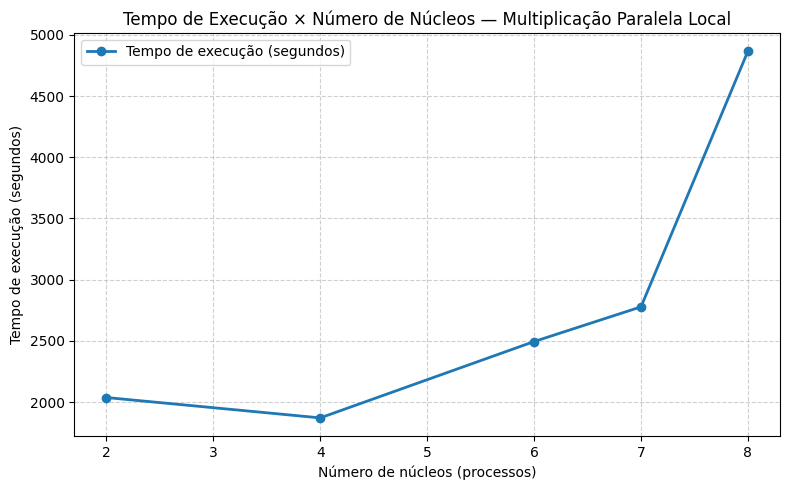

In [267]:
plot_por_processos(
    df, modo="paralelo_local",
    titulo="Tempo de Execução × Número de Núcleos — Multiplicação Paralela Local"
)

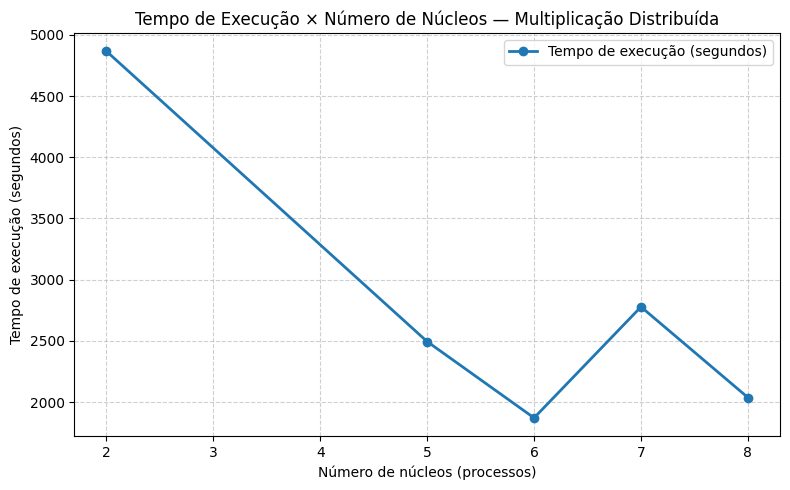

In [268]:
plot_por_processos(df, modo="distribuida",
                   titulo="Tempo de Execução × Número de Núcleos — Multiplicação Distribuída")

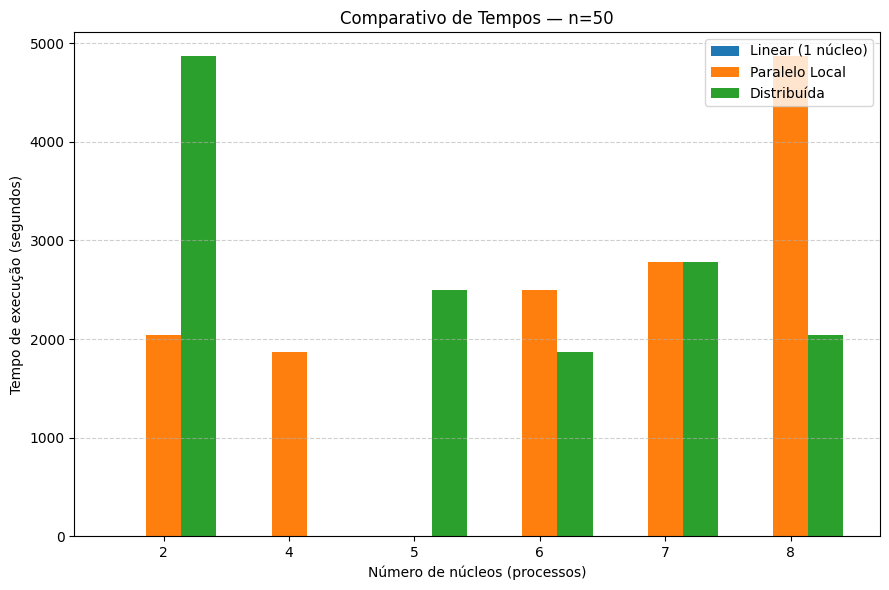

In [269]:
def plot_comparativo_barras(df: pd.DataFrame):

    lin = df[df["modo"] == "linear"].copy()
    if lin.empty:
        print("Aviso: sem 'linear' para comparativo.")
        return

    lin = lin.dropna(subset=["tempo_clock"]).sort_values("timestamp").reset_index(drop=True)
    if "tamanho_n" not in lin.columns:
        lin["tamanho_n"] = np.arange(50, 50*(len(lin)+1), 50)[:len(lin)]
    lin["tamanho_n"] = pd.to_numeric(lin["tamanho_n"], errors="coerce")
    lin = lin.dropna(subset=["tamanho_n"]).sort_values("tamanho_n")
    n_ref = int(lin["tamanho_n"].max())
    t_lin = float(lin.loc[lin["tamanho_n"].eq(n_ref), "tempo_clock"].iloc[-1])

    par = df[df["modo"] == "paralelo_local"][["num_processos","tempo_clock"]].dropna()
    dist = df[df["modo"] == "distribuida"][["num_processos","tempo_clock"]].dropna()

    par = par.sort_values("num_processos").drop_duplicates("num_processos", keep="last")
    dist = dist.sort_values("num_processos").drop_duplicates("num_processos", keep="last")

    procs = sorted(set(par["num_processos"]) | set(dist["num_processos"]))
    if not procs:
        print("Aviso: não há processos em 'paralelo_local' ou 'distribuida' para comparar.")
        return

    cmp_df = pd.DataFrame({"num_processos": procs})
    cmp_df["linear"] = t_lin
    cmp_df["paralelo_local"] = cmp_df["num_processos"].map(par.set_index("num_processos")["tempo_clock"])
    cmp_df["distribuida"]   = cmp_df["num_processos"].map(dist.set_index("num_processos")["tempo_clock"])

    x = np.arange(len(cmp_df))
    w = 0.28
    plt.figure(figsize=(9,6))
    plt.bar(x - w, cmp_df["linear"],          width=w, label="Linear (1 núcleo)")
    plt.bar(x,      cmp_df["paralelo_local"], width=w, label="Paralelo Local")
    plt.bar(x + w,  cmp_df["distribuida"],    width=w, label="Distribuída")
    plt.xticks(x, cmp_df["num_processos"].astype(int))
    plt.xlabel("Número de núcleos (processos)")
    plt.ylabel("Tempo de execução (segundos)")
    plt.title(f"Comparativo de Tempos — n={n_ref}")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_comparativo_barras(df)

Gráfico comparativo entre o tempo (em segundos) e a multiplicação paralela distribuída (múltiplos núcleos em 2 backends); 


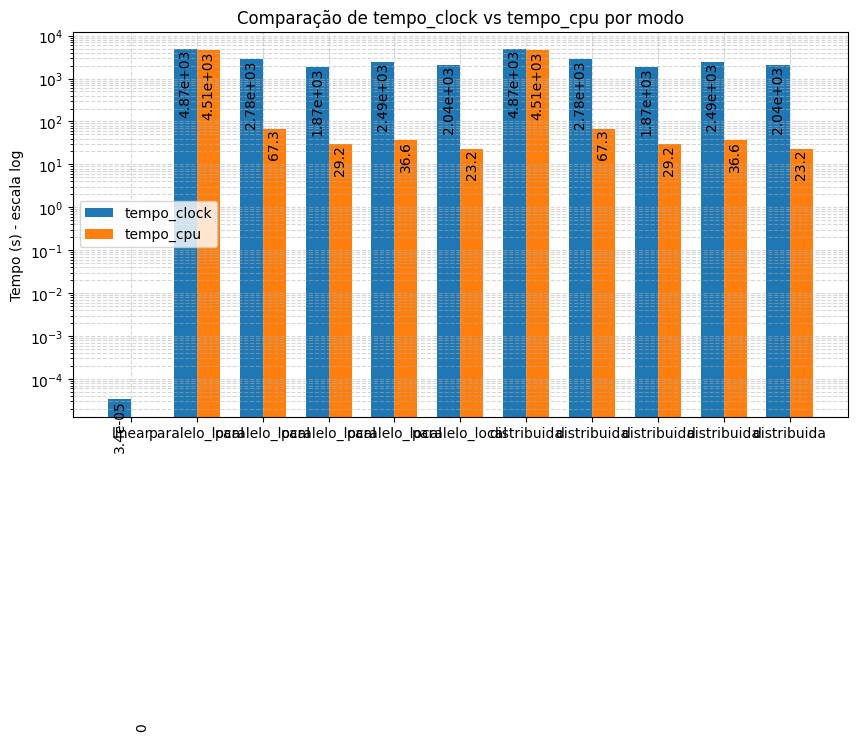

In [270]:
modes = df['modo'].astype(str).tolist()
tempo_clock = df['tempo_clock'].astype(float).tolist()
tempo_cpu = df['tempo_cpu'].astype(float).tolist()

x = list(range(len(modes)))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar([xi - width/2 for xi in x], tempo_clock, width=width, label='tempo_clock', color='C0')
plt.bar([xi + width/2 for xi in x], tempo_cpu, width=width, label='tempo_cpu', color='C1')

plt.xticks(x, modes)
plt.yscale('log')
plt.ylabel("Tempo (s) - escala log")
plt.title("Comparação de tempo_clock vs tempo_cpu por modo")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

for xi, tc, tp in zip(x, tempo_clock, tempo_cpu):
    plt.text(xi - width/2, tc if tc>0 else 1e-12, f"{tc:.3g}", ha='center', va='top', fontsize=10, rotation=90)
    plt.text(xi + width/2, tp if tp>0 else 1e-12, f"{tp:.3g}", ha='center', va='top', fontsize=10, rotation=90)

plt.show()

In [ ]:
dfb = pd.read_csv("results/benchmarks.csv")

subset = dfb.query("section=='gemm' and dtype=='float64'")
pivot = subset.pivot_table(index="n", values="value", columns="host", aggfunc='first').astype(float)
pivot.plot(kind="bar", figsize=(9,5))
plt.ylabel("GFLOPS (float64)")
plt.title("Benchmark GEMM por host")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

scalar = dfb.query("section=='scalar'")
pivot2 = scalar.pivot_table(index="metric", values="value", columns="host", aggfunc='first').astype(float)
pivot2.plot(kind="bar", figsize=(7,4))
plt.ylabel("Operações por segundo")
plt.title("Benchmark escalar (Python)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()